In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, panda_models, panda_datasets, panda_training
from lib.utils import file_utils, torch_utils, misc_utils

print(torch.__version__, np.__version__)

1.3.1 1.16.4


In [3]:
# Experiment configuration
experiment_name = "dpf_no_haptics"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': False,
    'vision_interval': 10,
}

In [4]:
# Create models & training buddy

dynamics_model = panda_models.PandaSimpleDynamicsModel(state_noise=(0.05))
measurement_model = panda_models.PandaMeasurementModel(units=32)

pf_model = dpf.ParticleFilterNetwork(dynamics_model, measurement_model)

buddy = torch_utils.TrainingBuddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"],
    log_dir="logs/pf",
    checkpoint_dir="checkpoints/pf"
)

Using device: cuda
No checkpoint found


# Dynamics Model Pre-Training

In [5]:
# dynamics_trainset = panda_datasets.PandaDynamicsDataset(
#     "data/pull-test.hdf5",
#     "data/push-test.hdf5",
#     **dataset_args
# )

In [6]:
# dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=256, shuffle=True, num_workers=2)

# for i in range(0):
#     print("Training epoch", i)
#     panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=10)
#     print()


# Measurement Model Pre-Training

In [7]:
measurement_trainset = panda_datasets.PandaMeasurementDataset(
    ("data/pull-test.hdf5", 1000),
    ("data/push-test.hdf5", 1000),
    std_dev=0.15,
    **dataset_args
)

Progress: [####################] 99.5%


In [8]:
measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=16)
for i in range(3):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
    print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=256, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()



..........[0.55%]..........[1.09%]..........[1.64%]..........[2.18%]..........[2.73%]..........[3.28%]..........[3.82%]..........[4.37%]..........[4.92%].........Saved checkpoint to path: checkpoints/pf/dpf_no_haptics-0000000000010000.ckpt
.[5.46%]..........[6.01%]..........[6.56%]..........[7.10%]..........[7.65%]..........[8.20%]..........[8.74%]..........[9.29%]..........[9.83%]..........[10.38%].........Saved checkpoint to path: checkpoints/pf/dpf_no_haptics-0000000000020000.ckpt
.[10.93%]..........[11.47%]..........[12.02%]..........[12.57%]..........[13.11%]..........[13.66%]..........[14.21%]..........[14.75%]..........[15.30%]..........[15.84%].........Saved checkpoint to path: checkpoints/pf/dpf_no_haptics-0000000000030000.ckpt
.[16.39%]......

KeyboardInterrupt: 

In [9]:
buddy.save_checkpoint(label="before_e2e_training")

Saved checkpoint to path: checkpoints/pf/dpf_no_haptics-before_e2e_training.ckpt


# End-to-end Training

In [10]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    ("data/pull-test.hdf5", 1000),
    ("data/push-test.hdf5", 1000),
    subsequence_length=20,
    particle_count=50,
    particle_variances=(.2,),
    **dataset_args
)

Parsed data: 20570 active, 8605 inactive
Keeping: 8605


In [11]:
##### Train end-to-end
pf_model.dynamics_model.state_noise = (0.1)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=64, shuffle=True, num_workers=2)
for i in range(1):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

Training epoch 0


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Epoch loss: 0.02002535


In [12]:
buddy.save_checkpoint()

Saved checkpoint to path: checkpoints/pf/dpf_no_haptics-0000000000039358.ckpt


# Model eval

In [13]:
eval_trajectories_list = []

def load_trajectories(label, validation, include_pull, include_push, max_count=10):
    if validation:
        # Validation set
        files = [
            ("data/pull-test-small.hdf5", max_count),
            ("data/push-test-small.hdf5", max_count)
        ]
    else:
        # Training set
        files = [
            ("data/pull-test.hdf5", max_count),
            ("data/push-test.hdf5", max_count)
        ]
    
    filtered_files = []
    if include_pull:
        filtered_files.append(files[0])
    if include_push:
        filtered_files.append(files[1])

    trajectories = panda_datasets.load_trajectories(
        *filtered_files,
        **dataset_args
    )
    eval_trajectories_list.append((label, trajectories))

load_trajectories("Validation all", validation=True, include_pull=True, include_push=True)
load_trajectories("Validation pull", validation=True, include_pull=True, include_push=False)
load_trajectories("Validation push", validation=True, include_pull=False, include_push=True)

load_trajectories("Training all", validation=False, include_pull=True, include_push=True)
load_trajectories("Training pull", validation=False, include_pull=True, include_push=False)
load_trajectories("Training push", validation=False, include_pull=False, include_push=True)

### Final Model

###############################
###############################
## Validation all
###############################
###############################
...................................


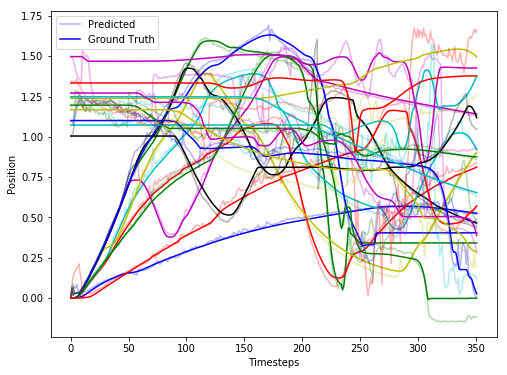

(20, 352, 1)
Position MSE:  0.025296358
###############################
###############################
## Validation pull
###############################
###############################
................................................................


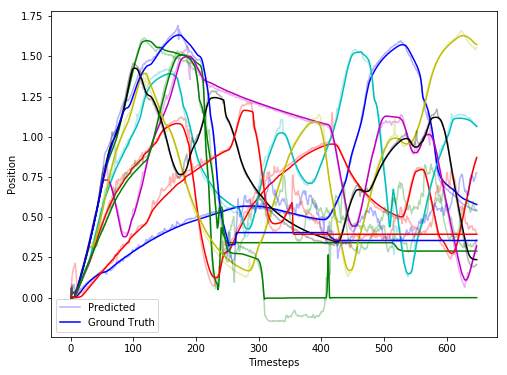

(10, 649, 1)
Position MSE:  0.016246414
###############################
###############################
## Validation push
###############################
###############################
...................................


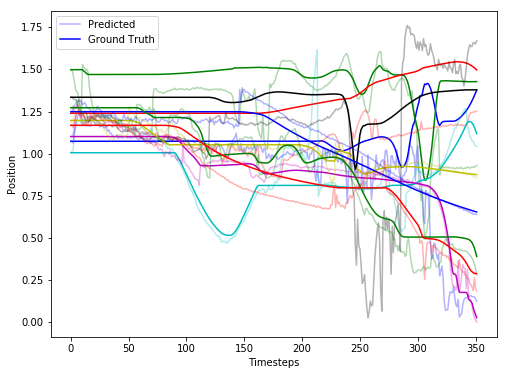

(10, 352, 1)
Position MSE:  0.04188711
###############################
###############################
## Training all
###############################
###############################
.......................................


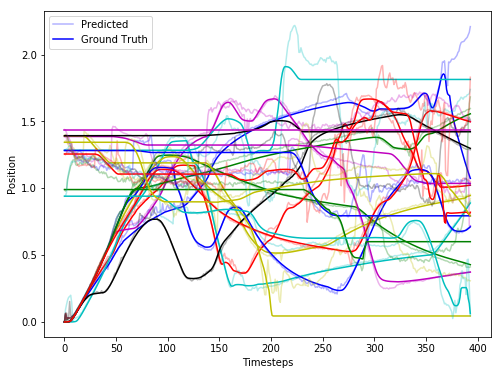

(20, 394, 1)
Position MSE:  0.026700394
###############################
###############################
## Training pull
###############################
###############################
............................................................................


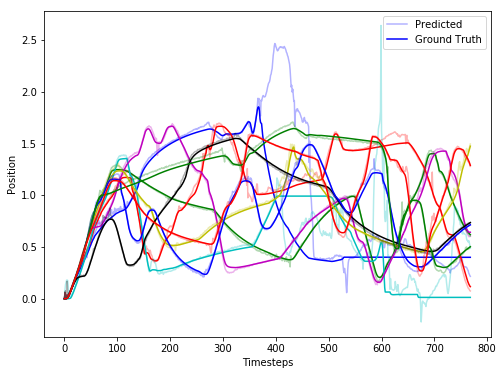

(10, 769, 1)
Position MSE:  0.03016135
###############################
###############################
## Training push
###############################
###############################
.......................................


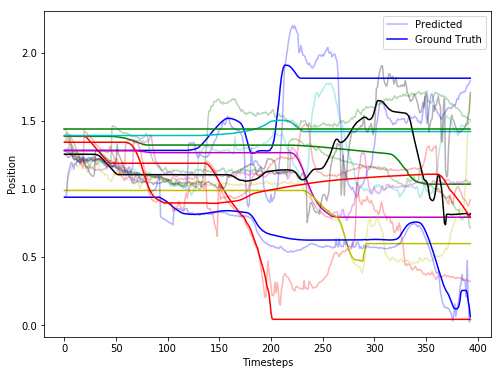

(10, 394, 1)
Position MSE:  0.049453937


In [14]:
pf_model.dynamics_model.state_noise = (0.1)

# Evaluate final model
for label, trajectories in eval_trajectories_list:
    print("###############################")
    print("###############################")
    print("##", label)
    print("###############################")
    print("###############################")
    pred, actual = panda_training.rollout(pf_model, trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
    panda_training.vis_rollout(pred, actual)

### Model without end-to-end training

Saved checkpoint to path: checkpoints/pf/dpf_no_haptics-0000000000039358.ckpt
checkpoints/pf/dpf_no_haptics-before_e2e_training.ckpt
Loaded checkpoint from path: checkpoints/pf/dpf_no_haptics-before_e2e_training.ckpt
###############################
###############################
## Validation all
###############################
###############################
...................................


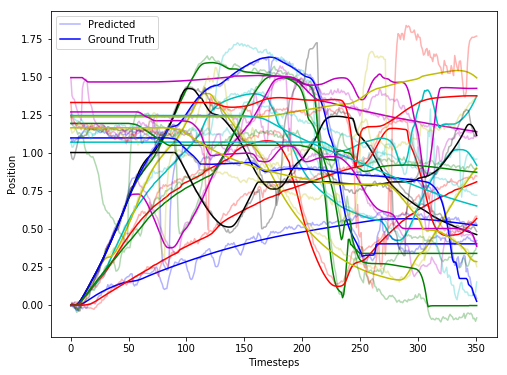

(20, 352, 1)
Position MSE:  0.032872688
###############################
###############################
## Validation pull
###############################
###############################
................................................................


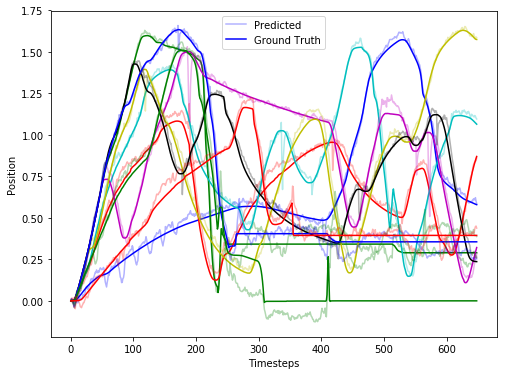

(10, 649, 1)
Position MSE:  0.0072824415
###############################
###############################
## Validation push
###############################
###############################
...................................


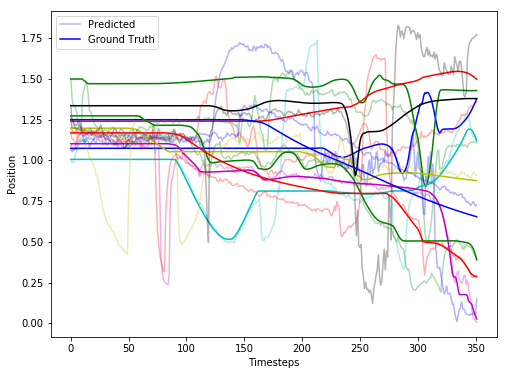

(10, 352, 1)
Position MSE:  0.063229285
###############################
###############################
## Training all
###############################
###############################
.......................................


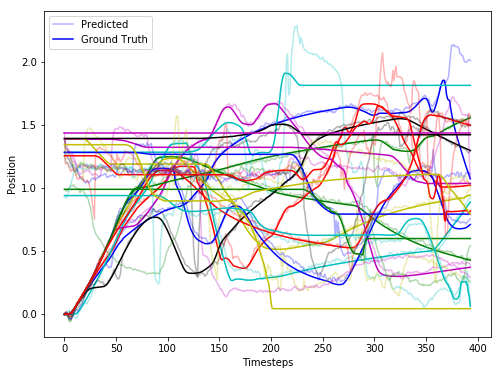

(20, 394, 1)
Position MSE:  0.10686249
###############################
###############################
## Training pull
###############################
###############################
............................................................................


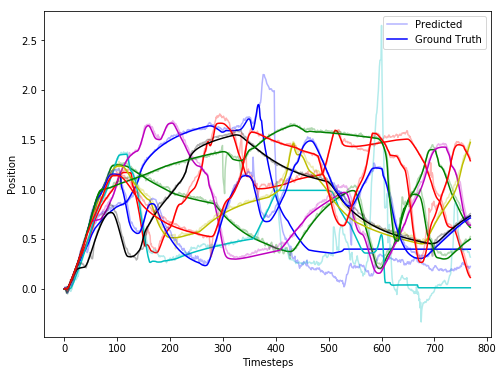

(10, 769, 1)
Position MSE:  0.02020049
###############################
###############################
## Training push
###############################
###############################
.......................................


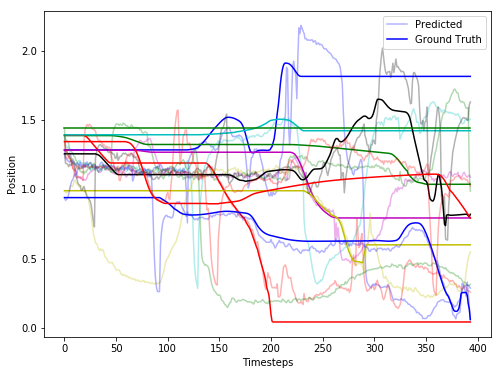

(10, 394, 1)
Position MSE:  0.20972496
Loaded checkpoint from path: checkpoints/pf/dpf_no_haptics-0000000000039358.ckpt


In [15]:
# Back up model
buddy.save_checkpoint()

# Load the pre-end-to-end-training version of the model & evaluate
buddy.load_checkpoint(label="before_e2e_training")
for label, trajectories in eval_trajectories_list:
    print("###############################")
    print("###############################")
    print("##", label)
    print("###############################")
    print("###############################")
    pred, actual = panda_training.rollout(pf_model, trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
    panda_training.vis_rollout(pred, actual)

# Restore model
buddy.load_checkpoint()